# Task Sequencer

#### <i>"Sometimes when you innovate, you make mistakes. It is best to admit them quickly, and get on with improving your other innovations."<i> -Steve Jobs

This is a tool which will calculate the optimal order to approach tasks in a project where there are several different tasks that need to be done that have a certain probability of failing and will take a certain time to complete.

When we are uncertain about the feasibility of a project, we should strive to get as much information about the difficulty as quickly as possible. This suggests starting with tasks with a high failure rate.

The idea behind this approach is and some other useful information is discussed here. https://cs.stanford.edu/~jsteinhardt/ResearchasaStochasticDecisionProcess.html

### Imports and settings

In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [1]:
import ipywidgets
import ipysheet
import pandas as pd
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math

from time import process_time

## Code Body

In [10]:
def df_from_sheet(sheet):
    df = ipysheet.to_dataframe(sheet)
    df = fill_blanks(df)
    df = nums_to_float(df)
    df = trim_df(df)
    return df

def fill_blanks(df):
    df.fillna(0, inplace=True)
    df.replace(["", "0"], 0, inplace=True)
    return df

def trim_df(df):
    zero_row_bool = (df.values==0).all(axis=1)
    zero_row_loc = np.where(zero_row_bool)[0]
    if zero_row_loc.size == 0:
        first_zero_row=df.shape[0]
    else:
        first_zero_row = zero_row_loc[0]
    zero_col_bool = (df.values==0).all(axis=0)
    zero_col_loc = np.where(zero_col_bool)[0]
    if zero_col_loc.size == 0:
        first_zero_col = df.shape[1]
    else:
        first_zero_col = zero_col_loc[0]
    return df.iloc[:first_zero_row,:first_zero_col]
    
def nums_to_float(df):
    df.iloc[:,1:] = df.iloc[:,1:].astype(float)
    return df

def build_sheet(task_report="task_sheet.csv",
               rows=10, cols=10):
    labels = (['task', 'time', 'probability'] 
              + ["d" + str(i + 1) 
                 for i in range(cols - 3)])
    sheet = sheet_from_df(task_report, rows, 
                          cols, labels)
    if sheet:
        return sheet
    sheet = sheet_from_scratch(rows, cols, labels)
    return sheet

def sheet_from_df(task_report, rows, 
                  cols, labels):
    try:
        sheet = ipysheet.sheet(
            rows=rows,
            columns=cols,
            column_headers=labels)
        df = pd.read_csv(task_report)
        data = np.zeros([rows, cols], dtype=object)
        data[:df.shape[0], :df.shape[1]] = df.values
        ipysheet.cell_range(data)
        return sheet
    except:
        return None
    
def sheet_from_scratch(rows, cols, labels):
    sheet = ipysheet.sheet(
        rows=rows,
        columns=cols,
        column_headers=labels)
    data = [[None for i in range(cols)] 
            for i in range(rows)]
    ipysheet.cell_range(data)
    return sheet

def gen_perms(df):
    rows=df.shape[0]
    return permutations(range(1,rows+1))

def validate_perms(perms, deps):
    valid_perms = []
    for perm in perms:
        if check_perm(perm, deps) == True:
            valid_perms.append(perm)
    return valid_perms

def check_perm(perm, deps):
    prev_ind = [0]
    for index in perm:
        prev_ind.append(index)
        dep = deps[index-1, :]
        sub_true = all(elem in prev_ind for elem in dep)
        if sub_true is False:
            return False
        elif index == perm[-1]:
            return True

def sort_rates(times, probs):
    return (np.flip(np.argsort(
        1/times*np.log(1/(1-probs)))) + 1)
        
def get_expected_times(perms, df):
    sums = []
    for perm in perms:
        prob_col = df['probability'][np.array(perm) - 1].values
        prob_comp = 1 - prob_col
        prob_mat = expand_to_lower_tri_mat(prob_comp)
        prod_arr = prob_prod_arr(prob_mat, prob_col)
        time_col = df['time'][np.array(perm) - 1].values
        time_mat = expand_to_lower_tri_mat(time_col)
        sum_arr = sum_times(time_mat)
        prob_succ = np.prod(prob_comp)
        total_time = np.sum(time_col)
        exp_time_given_fail = np.sum(prod_arr*(sum_arr 
                    + time_col
                    *(np.log((prob_comp)**(prob_comp)) 
                    + prob_col)
                    /np.log((1/prob_comp)**prob_col)))
        prob_fail = 1 - np.prod(prob_comp)
        exp_time = (prob_succ*total_time 
                    + exp_time_given_fail*prob_fail)
        sums.append(exp_time)
    return sums
    
def expand_to_lower_tri_mat(arr):
    two_d_arr = np.expand_dims((arr), 0)
    square_mat = np.repeat(two_d_arr,
                             repeats=arr.shape[0],
                             axis=0)
    return np.tril(square_mat)
    
def prob_prod_arr(prob_mat, prob_col):
    np.fill_diagonal(prob_mat, 0)
    ones = np.triu(np.ones(np.shape(prob_mat)))
    np.fill_diagonal(ones, 0)
    return np.prod(ones + prob_mat + np.diag(prob_col), 1)

def sum_times(time_mat):
    np.fill_diagonal(time_mat, 0)
    return np.sum(time_mat, 1)

def adj_transposes(arr):
    """returns a matrix where each row
    is one of the n-1 adjacent transposes"""
    reps_mat = repeat_array_as_matrix(arr, len(arr)-1)
    for i in range(len(arr)-1):
        ith_row = reps_mat[i,:]
        ith_row[i], ith_row[i+1] = ith_row[i+1], ith_row[i]
    return reps_mat

def find_kids(row, arr, deps):
    '''Returns the inidicies of srtd_rates where
    the dependents of task in "row" are located'''
    child_rows = np.argwhere(deps==row)[:,0] + 1
    child_loc = np.where(np.in1d(arr, child_rows))[0]
    return child_loc

def repeat_array_as_matrix(arr, reps):
    '''e.g. array([1,2]) to array([[1,2],
                                    [1,2]])'''
    matrix_head = np.expand_dims(arr, axis=0)
    return np.repeat(matrix_head,
                      repeats=reps,
                        axis=0)

def find_parents(row, arr, deps):
    '''Returns the inidicies of arr where
    the tasks that task in row is dependent on
    are located'''
    dep = deps[row-1] #minus 1 cause index
    parent_rows = dep[np.nonzero(dep)] #rid zeros
    parent_loc = np.where(np.in1d(arr, parent_rows))[0]
    return parent_loc

def calc_disarray(arr, deps):
    total_disarray = 0
    for task_loc, task in enumerate(arr):
        task_kids_loc = find_kids(task, arr, deps)
        task_pars_loc = find_parents(task, arr, deps)
        total_disarray += element_disarray(task_kids_loc,
                                           task_pars_loc,
                                           task_loc)
    return total_disarray

def find_least_disarrayed(mat, deps):
    disarray_counts = np.zeros(mat.shape[0])
    for i, row in enumerate(mat):
        disarray_counts[i] = calc_disarray(row, deps)
    min_disarray = np.amin(disarray_counts)
    min_ind = np.where(disarray_counts==min_disarray)[0]
    return mat[min_ind,:]

def element_disarray(kid_loc, par_loc, loc):
    kids_to_left = np.extract(kid_loc<loc, kid_loc)
    pars_to_right = np.extract(par_loc>loc, par_loc)
    return (np.sum(loc - kids_to_left) + 
            np.sum(pars_to_right - loc))

def check_unique(new_srtd_rates, prev):
    for i, row in enumerate(new_srtd_rates):
        if (prev==row).all(axis=1).any():
            new_srtd_rates[i,:] = np.zeros(
                new_srtd_rates.shape[1])
    new_srtd_rates = new_srtd_rates[~np.all(
        new_srtd_rates==0, axis=1)]
    return new_srtd_rates

def quick_best_order(arr, df, deps, count, prev):
    count += 1
    transposes = adj_transposes(arr)
    transposes = check_unique(transposes, prev)
    least_disarrayed = find_least_disarrayed(transposes, deps)
    expected_times = get_expected_times(least_disarrayed, df)
    best = least_disarrayed[np.argmin(expected_times)]
    prev = np.append(prev, np.expand_dims(best, 0), 0)
    if check_perm(best, deps)==True:
        return best
    elif count<50:
        return quick_best_order(best, df, deps, count, prev)
    else:
        return ("Error: Make sure dependencies don't produce"
                + " a contradiction.")

def sort_rates(times, probs):
    return (np.flip(np.argsort(
        1/times*np.log(1/(1-probs)))) + 1)


    
def plot_fig(sorted_sums):
    fig, axs = plt.subplots(1, 1)
    axs.plot(np.arange(len(sorted_sums)), sorted_sums)
    plt.xticks([])
    plt.title('Distribution of Times')
    plt.show()

def main(df):
    deps = df.filter(like='d').values
    times = df['time'].values
    probs = df['probability'].values
    srtd_rates = sort_rates(times, probs)
    prev = np.zeros([1,df.shape[0]])
    rows = df.shape[0]
    if rows < 10:
        perms = gen_perms(df)
        valid_perms = validate_perms(perms, deps)
        sums = get_expected_times(valid_perms, df)
        sorted_sums = np.sort(sums)
        best_order = valid_perms[np.argmin(sums)]
        plot_fig(sorted_sums)
        print("the optimal order is " + str(best_order) + "\r\n"
              + " and the expected time is" + "\r\n"
              + " " + str(sorted_sums[0]) + ".", end="\r\n") 
            
    else:
        best = quick_best_order(srtd_rates, df, deps, 0, prev)
        print("The optimal order is " + "\r\n" 
                + str(best) + "\r\n"
                + "and the expected time is " + "\r\n"
                + str(get_expected_times(
                    np.expand_dims(best, 0), df)[0]) + ".", 
              end="\r\n")

## Data Entry

Add your data here just like you would on an Excel spreadsheet. 

Note: For the dependency columns, type the row numbers of the tasks that task A depends on in task A's dependencies (In the example, "Eat a frog" depends on "Eat a bigger one", and eat a bigger one is listed on row 2, so I put a 2 in d1, row 1).

Note: To adjust number of columns or number of rows, change the numbers in the code block below (default is 5 for each).

##### Important: provide your estimate for the probability of failing on the task, not succeeding.

In [3]:
sheet = build_sheet()
sheet

Sheet(cells=(Cell(column_end=9, column_start=0, row_end=9, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [4]:
df = df_from_sheet(sheet)
df

,task,time,probability,d1,d2,d3,d4,d5
0,A,1.0,0.10,2.0,3.0,0.0,0.0,0.0
1,B,2.0,0.25,0.0,0.0,0.0,0.0,0.0
2,C,3.0,0.40,0.0,6.0,0.0,0.0,0.0
3,E,1.2,0.10,5.0,0.0,0.0,0.0,0.0
4,F,3.0,0.10,2.0,3.0,6.0,7.0,9.0
5,G,7.0,0.13,7.0,8.0,0.0,0.0,0.0
6,H,5.0,0.53,0.0,0.0,0.0,0.0,0.0
7,I,2.0,0.80,9.0,7.0,0.0,0.0,0.0
8,J,1.0,0.10,0.0,0.0,0.0,0.0,0.0


In [132]:
df.to_csv('task_sheet.csv', index=False)

# Report

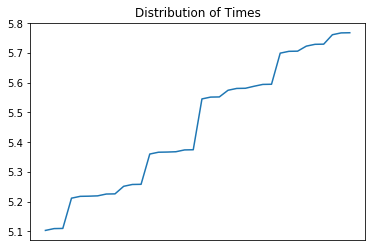

the optimal order is (7, 9, 8, 2, 6, 3, 1, 5, 4)
 and the expected time is
 5.103410709646576.


In [11]:
main(df)

### TIP: If you can't see the whole sheet just right click and hit open in new window

## Appendix A

We want to calculate the expected time to termination for a given sequence of $n$ tasks. We either terminate by completing all of our tasks or failing on one of them. Let $T$ be the random variable denoting time until termination. $S$ be a random variable indicating whether we have succeeded or not.
From the law of total expectation, 

$$
\text{E}[T] = \text{E}[\text{E}[T \vert S]] = \text{P}(S = 1)\text{E}[T \vert S = 1] + \text{P}(S = 0)\text{E}[T \vert S = 0].
$$

To start we will focus our calculation on $\text{E}[T \vert S = 0]$. Let $L_i$ be the event that we fail on the $i^{\text{th}}$ task, for $i \in \{ 1, \dots, n\}$. Observe that the possible events given we fail are $L_1, \dots, L_n$. Thus, $L_1, \dots, L_n$ partitions $\{S = 0\}$. This means that we can apply the law of total expectation again to yield


$$
\text{E}[T \vert S = 0] = \text{P}(L_1)\text{E}[T \vert L_1] + \dots + \text{P}(L_n)\text{E}[T \vert L_n].
$$

$\text{P}(L_i)$ is determined by the probability of getting to task $i$ and the probability of failing at task $i$. It can be calculated with

$$
\text{P}(L_i) = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}).
$$

Next, to calculate $\text{E}[T \vert L_i]$, let the starting time $t_{s}$ denote the time at which we start the $i^{\text{th}}$ task. Let $t_{i}$ denote the time the $i^{\text{th}}$ task takes us. Let $T_{i}$ be the random variable denoting the time spent on task $i$ given that we fail on task $i$. Suppose that the task fails at a rate $\lambda$ which is independent of how long we have been working on it. Then $f(t) = \lambda e^{-\lambda t}$ is the probability density function for failure time if the task is allowed to continue indefinately until we fail. We have assumed that the task will fail before $t_{i}$. It therefore follows that the probability density function for $T_{i}$ is $f(t \vert t< t_{i})$. This function has is given by

$$
f(t \vert t \leq t_{i})= \begin{cases}
\frac{1}{A}\lambda e^{-\lambda t}, \hspace{1cm} 0 \leq t \leq t_{i}, \\
0, \hspace{1.8cm} \text{otherwise}.
\end{cases}
$$

Where $A$ denotes the area under the curve of $f(t)$ from $0$ to $t_{i}$. To calculate $A$, we have

$$
A = \int_0^{t_{i}} \lambda e^{-\lambda t} dt = 1 - e^{-\lambda t_{i}}.
$$

To calculate $\text{E}[T]$ we now have

$$
\text{E}[T \vert L_i] = t_0 + \frac{1}{ 1 - e^{-\lambda t_{i}}} \int_0^{t_{i}} \lambda t e^{-\lambda t} dt,
$$

which after some simplification yeilds

$$
\text{E}[T \vert L_i] = t_0 + \frac{1 - t_{i} \lambda e^{-\lambda t_{i}} - e^{-\lambda t_{i}}}{\lambda(1 - e^{-\lambda t_{i}})}.
$$

$\lambda$ is currently an unknown value. The values we are given are $t_i$ and the probability of failure $p_i$. We need to write $\lambda$ in terms of these known quantities. This can be done with the following equation.

$$
1 - e^{- \lambda t_i} = p_{i},
$$

which yields

$$
\lambda = \frac{1}{t_i}\ln \Big{(}\frac{1}{1 - p_{i}}\Big{)}
$$

By substituting this value of $\lambda$ into the above equation and simplifying we get

$$
\text{E}[T \vert L_i] = t_0 + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}}.
$$

Thus, $\text{P}(L_i)\text{E}[T \vert L_i]$ is given by

$$
\text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}t_0 + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)}.
$$

Note that for each $i \in \{1, \dots n\}$, $t_0$ is the time to complete the $1^{\text{st}}$ through $i - 1^{\text{th}}$ task. Then we can write $t_0$ as

$$
t_0 = \sum_{j = 1}^{i - 1} t_j.
$$

This implies that our final equation for $\text{P}(L_i)\text{E}[T \vert L_i]$ is given by

$$
\text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)}.
$$

To find $\text{E}[T \vert S = 1]$, we must simply sum through all of the terms.

$$
\text{E}[T \vert S = 1] = \sum_{i = 1}^n \Bigg{(}p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)} \Bigg{)}
$$

Next, by looking at the complement of $\text{P}(S = 0)$ we have

$$
\text{P}(S = 0) = 1 - \text{P}(S = 1) = 1 - \prod_{i = 1}^{n} (1 - p_i).
$$

$\text{E}[T \vert S = 1]$ is simply the expected time to success, which is simply the sum of the expected times to complete each task given by

$$
\text{E}[T \vert S = 1] = \sum_{i = 1}^n t_i
$$

Putting all of this together, we find

$$
\text{E}[T] = \Big{(}1 - \prod_{i = 1}^{n} (1 - p_i)\Big{)}\sum_{i = 1}^n t_i + \prod_{i = 1}^{n} (1 - p_i) \Bigg{(} \sum_{i = 1}^n \Bigg{(} p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)} \Bigg{)} \Bigg{)}
$$